# Analysis of Traffic Accidents in Boulder County

Traffic Data via: https://www.codot.gov/safety/impaired-driving/planahead/safe-ride-options/boulder.html

Weather Data via: https://www.boulder.noaa.gov/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
traffic_df = pd.read_excel('/content/drive/My Drive/CDOTRM_CD_Crash_Listing_2019.xlsx')
traffic_df = pd.DataFrame(traffic_df)

In [24]:
weather_df = pd.read_excel('/content/drive/My Drive/2019_snow_data.xlsx')
weather_df = pd.DataFrame(weather_df)

In [7]:
# only keep records of accidents in Boulder County
boulder_traffic_df = traffic_df[traffic_df['COUNTY'] == 'BOULDER']

# drop unneeded columns
columns_to_keep = ['SYSTEM', 'DATE', 'TIME', 'LATITUDE', 'LONGITUDE',
                   'SEVERITY', 'ROAD_DESC','VEHICLES',
                  'CONDITION', 'WEATHER','ACCTYPE', 'DRIVER_1', 'VEHICLE_1','RUCODE',
                    'VEH_MOVE_1', 'FACTOR_1',
                   'LIMIT1','SPEED_1','AGE_1', 'STATE_1', 'WAN_TYPE',
                   'SEX_1']
boulder_traffic_df = boulder_traffic_df[columns_to_keep]

In [8]:
boulder_traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5574 entries, 32 to 121772
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   SYSTEM      5574 non-null   object        
 1   DATE        5574 non-null   datetime64[ns]
 2   TIME        5572 non-null   float64       
 3   LATITUDE    5574 non-null   float64       
 4   LONGITUDE   5574 non-null   float64       
 5   SEVERITY    5574 non-null   object        
 6   ROAD_DESC   5574 non-null   object        
 7   VEHICLES    5574 non-null   int64         
 8   CONDITION   5574 non-null   object        
 9   WEATHER     5574 non-null   object        
 10  ACCTYPE     5566 non-null   object        
 11  DRIVER_1    5574 non-null   object        
 12  VEHICLE_1   5574 non-null   object        
 13  RUCODE      5574 non-null   object        
 14  VEH_MOVE_1  5574 non-null   object        
 15  FACTOR_1    5574 non-null   object        
 16  LIMIT1      5574 non-null 

## CDOT Data Cleaning

In [13]:
# Remove rows with null values in TIME and ACCTYPE
boulder_traffic_df = boulder_traffic_df.dropna(subset=['TIME', 'ACCTYPE'])

# Drop rows where 'LIMIT1' or 'SPEED_1' column has value 'UK'
boulder_traffic_df = boulder_traffic_df[~boulder_traffic_df['LIMIT1'].eq('UK')]
boulder_traffic_df = boulder_traffic_df[~boulder_traffic_df['SPEED_1'].eq('UK')]

# Reset index after dropping rows
boulder_traffic_df = boulder_traffic_df.reset_index(drop=True)

# VEHICLE_1 value count under 50 put into 'OTHER'
vehicle_counts = boulder_traffic_df['VEHICLE_1'].value_counts()
boulder_traffic_df['VEHICLE_1'] = boulder_traffic_df['VEHICLE_1'].apply(lambda x: 'OTHER' if vehicle_counts[x] < 50 else x)

# Replace W/VIS into base category safely
condition_replacements = {
    'SNOWY W/VIS ICY ROAD TREATMENT': 'SNOWY',
    'DRY W/VIS ICY ROAD TREATMENT': 'DRY',
    'ICY W/VIS ICY ROAD TREATMENT': 'ICY',
    'SLUSHY W/VIS ICY ROAD TREATMENT': 'SLUSHY',
    'WET W/VIS ICY ROAD TREATMENT': 'WET'
}
boulder_traffic_df = boulder_traffic_df.assign(
    CONDITION=boulder_traffic_df['CONDITION'].replace(condition_replacements)
)

# Remove CONDITION values with less than 5 occurrences
condition_counts = boulder_traffic_df['CONDITION'].value_counts()
conditions_to_keep = condition_counts[condition_counts >= 5].index
boulder_traffic_df = boulder_traffic_df[boulder_traffic_df['CONDITION'].isin(conditions_to_keep)]

# Replace null values in SEX_1 with 'U'
boulder_traffic_df = boulder_traffic_df.assign(
    SEX_1=boulder_traffic_df['SEX_1'].fillna('U')
)

# Filter outliers in LATITUDE and LONGITUDE
boulder_traffic_df = boulder_traffic_df[
    (boulder_traffic_df['LATITUDE'].between(39.6, 40.4)) &
    (boulder_traffic_df['LONGITUDE'].between(-105.7, -104.8))
]

# Convert DATE column to datetime
boulder_traffic_df = boulder_traffic_df.assign(
    DATE=pd.to_datetime(boulder_traffic_df['DATE'])
)

## CDOT Feature Engineering

In [15]:
# New col for speed vs limit (- MPH  below limit, + MPH above limit, 0 at limit)
boulder_traffic_df['SPEED_1'] = pd.to_numeric(boulder_traffic_df['SPEED_1'], errors='coerce')
boulder_traffic_df['LIMIT1'] = pd.to_numeric(boulder_traffic_df['LIMIT1'], errors='coerce')

boulder_traffic_df['SPEED_VS_LIMIT'] = (boulder_traffic_df['SPEED_1'] - boulder_traffic_df['LIMIT1'])

# Create IN_STATE col from STATE_1
boulder_traffic_df['IN_STATE'] = (boulder_traffic_df['STATE_1'] == 'CO').astype(int)
boulder_traffic_df.drop(columns=['STATE_1'], inplace=True)

# Create NO IMPAIRMENT bool col
boulder_traffic_df['IMPAIRMENT'] = (boulder_traffic_df['DRIVER_1'] != 'NO IMPAIRMENT SUSPECTED').astype(int)
boulder_traffic_df.drop(columns=['DRIVER_1'], inplace=True)

# Create speeding bol col
boulder_traffic_df['SPEEDING'] = (boulder_traffic_df['SPEED_VS_LIMIT'] > 0).astype(int)

# Replace 'URBAN' with 1 and RURAL with 0 in the 'RUCODE' column
boulder_traffic_df['URBAN'] = (boulder_traffic_df['RUCODE'] == 'URBAN').astype(int)
boulder_traffic_df.drop(columns=['RUCODE'], inplace=True)

# Bool col for animal from WAN_TYPE
boulder_traffic_df['ANIMAL'] = boulder_traffic_df['WAN_TYPE'].notna().astype(int)
boulder_traffic_df.drop(columns=['WAN_TYPE'], inplace=True)

In [16]:
boulder_traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5145 entries, 0 to 5144
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   SYSTEM          5145 non-null   object        
 1   DATE            5145 non-null   datetime64[ns]
 2   TIME            5145 non-null   float64       
 3   LATITUDE        5145 non-null   float64       
 4   LONGITUDE       5145 non-null   float64       
 5   SEVERITY        5145 non-null   object        
 6   ROAD_DESC       5145 non-null   object        
 7   VEHICLES        5145 non-null   int64         
 8   CONDITION       5145 non-null   object        
 9   WEATHER         5145 non-null   object        
 10  ACCTYPE         5145 non-null   object        
 11  VEHICLE_1       5145 non-null   object        
 12  VEH_MOVE_1      5145 non-null   object        
 13  FACTOR_1        5145 non-null   object        
 14  LIMIT1          5145 non-null   int64         
 15  SPEE

## NOAA Data Cleaning

In [18]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           365 non-null    datetime64[ns]
 1   Maximum T      365 non-null    int64         
 2   Minimum T      365 non-null    int64         
 3   Precipitation  365 non-null    object        
 4      Snow        365 non-null    object        
 5   Snow Depth     365 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 17.2+ KB


In [25]:
# Match date to traffic data format
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
weather_df.rename(columns={'Date': 'DATE'}, inplace=True)

# Match labeling
weather_df.rename(columns={
    'Maximum T': 'MAX_T',
    'Minimum T': 'MIN_T',
    'Precipitation': 'PRECIPITATION',
    '   Snow': 'SNOW',
    'Snow Depth': 'SNOW_DEPTH'
}, inplace=True)

# Convert columns to string first, then replace 'T' and convert to float
for col in ['PRECIPITATION', 'SNOW', 'SNOW_DEPTH']:
    weather_df[col] = weather_df[col].astype(str).replace('T', '0.01' if col == 'PRECIPITATION' else '0.1').astype(float)

In [26]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DATE           365 non-null    datetime64[ns]
 1   MAX_T          365 non-null    int64         
 2   MIN_T          365 non-null    int64         
 3   PRECIPITATION  365 non-null    float64       
 4   SNOW           365 non-null    float64       
 5   SNOW_DEPTH     365 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 17.2 KB


## Data Merging

In [29]:
df = pd.merge(boulder_traffic_df, weather_df, on='DATE', how='left')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5145 entries, 0 to 5144
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   SYSTEM          5145 non-null   object        
 1   DATE            5145 non-null   datetime64[ns]
 2   TIME            5145 non-null   float64       
 3   LATITUDE        5145 non-null   float64       
 4   LONGITUDE       5145 non-null   float64       
 5   SEVERITY        5145 non-null   object        
 6   ROAD_DESC       5145 non-null   object        
 7   VEHICLES        5145 non-null   int64         
 8   CONDITION       5145 non-null   object        
 9   WEATHER         5145 non-null   object        
 10  ACCTYPE         5145 non-null   object        
 11  VEHICLE_1       5145 non-null   object        
 12  VEH_MOVE_1      5145 non-null   object        
 13  FACTOR_1        5145 non-null   object        
 14  LIMIT1          5145 non-null   int64         
 15  SPEE

## Descriptive Analysis

<ipython-input-71-d4bd1fe5b80b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  severity_plot = sns.countplot(x='SEVERITY', data=df, ax=ax, order=df['SEVERITY'].value_counts().index, palette='Blues')


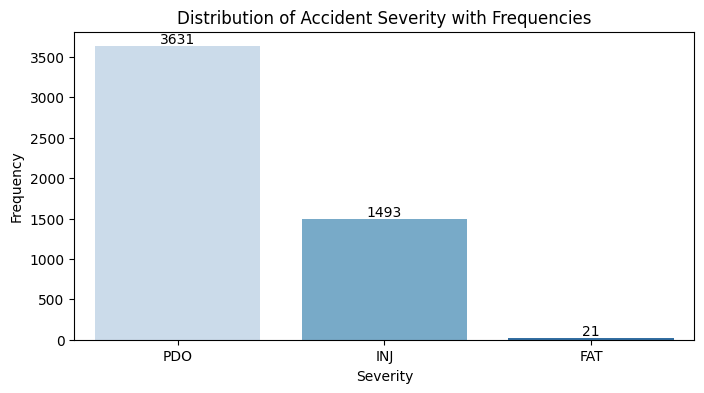

In [71]:
fig, ax = plt.subplots(figsize=(8, 4))
severity_plot = sns.countplot(x='SEVERITY', data=df, ax=ax, order=df['SEVERITY'].value_counts().index, palette='Blues')
ax.set_title('Distribution of Accident Severity with Frequencies')
ax.set_xlabel('Severity')
ax.set_ylabel('Frequency')

for p in severity_plot.patches:
    severity_plot.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                           textcoords='offset points')

plt.show()

<ipython-input-72-11fa9a916a99>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='SEVERITY', y='SPEED_VS_LIMIT', data=df, ax=ax, order=df['SEVERITY'].value_counts().index, palette='Blues')


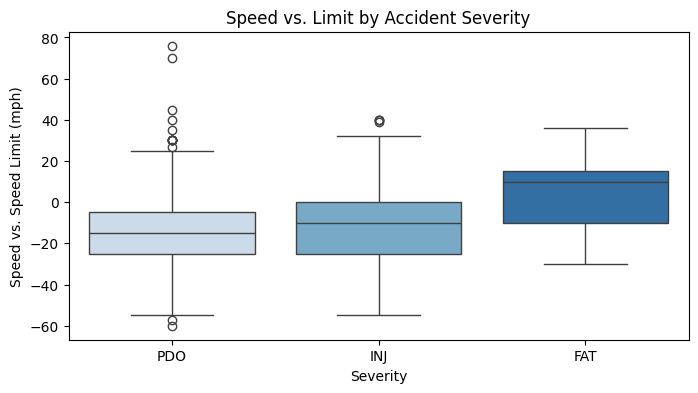

In [72]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(x='SEVERITY', y='SPEED_VS_LIMIT', data=df, ax=ax, order=df['SEVERITY'].value_counts().index, palette='Blues')
ax.set_title('Speed vs. Limit by Accident Severity')
ax.set_xlabel('Severity')
ax.set_ylabel('Speed vs. Speed Limit (mph)')

plt.show()

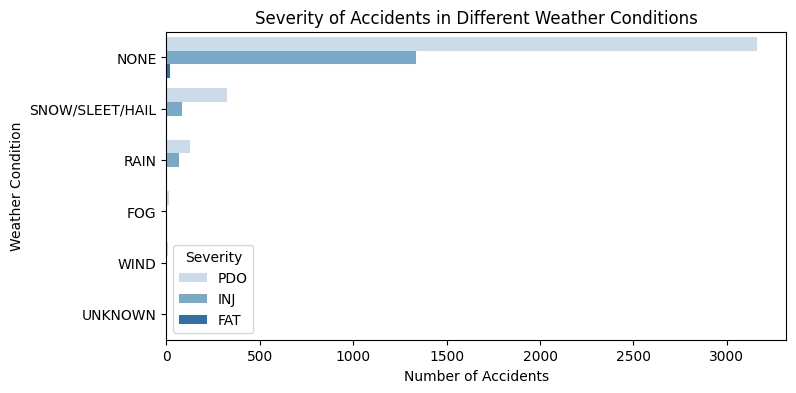

In [73]:
plt.figure(figsize=(8, 4))
severity_weather_plot = sns.countplot(y='WEATHER', hue='SEVERITY', data=df, order=df['WEATHER'].value_counts().index, palette='Blues')
plt.title('Severity of Accidents in Different Weather Conditions')
plt.xlabel('Number of Accidents')
plt.ylabel('Weather Condition')
plt.legend(title='Severity')
plt.show()

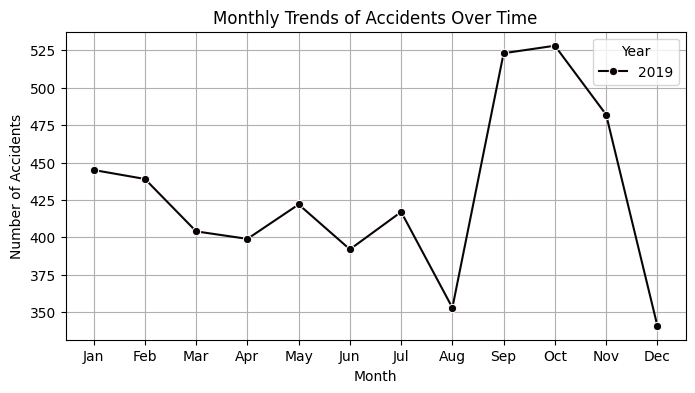

In [79]:
# Trends of accidents over time
df['DATE'] = pd.to_datetime(df['DATE'])
df['MONTH'] = df['DATE'].dt.month
df['YEAR'] = df['DATE'].dt.year

accidents_over_time = df.groupby(['YEAR', 'MONTH']).size().reset_index(name='COUNT')

pivot_table = accidents_over_time.pivot(index='MONTH', columns='YEAR', values='COUNT')

plt.figure(figsize=(8, 4))
time_series_plot = sns.lineplot(x='MONTH', y='COUNT', hue='YEAR', data=accidents_over_time, marker='o', palette='mako')
plt.title('Monthly Trends of Accidents Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.legend(title='Year')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

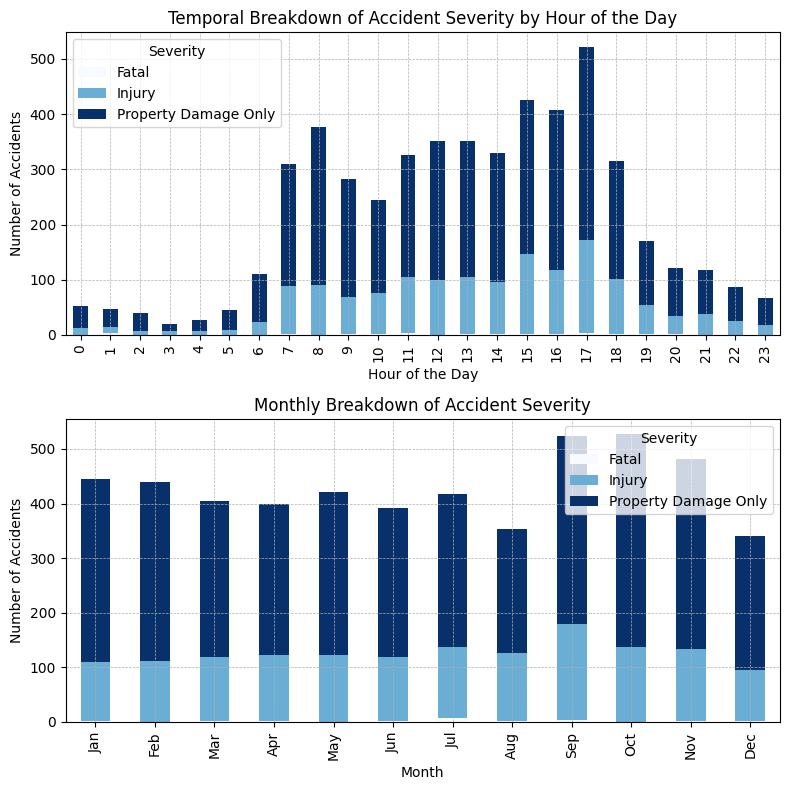

In [70]:
# Extract hour from TIME
df['HOUR'] = df['TIME'] // 100

temporal_breakdown = df.groupby(['HOUR', 'SEVERITY']).size().unstack(fill_value=0)

df['DATE'] = pd.to_datetime(df['DATE'])
df['MONTH'] = df['DATE'].dt.month

monthly_breakdown = df.groupby(['MONTH', 'SEVERITY']).size().unstack(fill_value=0)

fig, axes = plt.subplots(2, 1, figsize=(8, 8))

temporal_breakdown.plot(kind='bar', ax=axes[0], stacked=True, colormap='Blues')
axes[0].set_title('Temporal Breakdown of Accident Severity by Hour of the Day')
axes[0].set_xlabel('Hour of the Day')
axes[0].set_ylabel('Number of Accidents')
axes[0].legend(title='Severity', labels=['Fatal', 'Injury', 'Property Damage Only'])
axes[0].set_xticks(range(24))
axes[0].set_xticklabels(range(24))
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

monthly_breakdown.plot(kind='bar', ax=axes[1], stacked=True, colormap='Blues')
axes[1].set_title('Monthly Breakdown of Accident Severity')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Accidents')
axes[1].legend(title='Severity', labels=['Fatal', 'Injury', 'Property Damage Only'])
axes[1].set_xticks(range(12))
axes[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

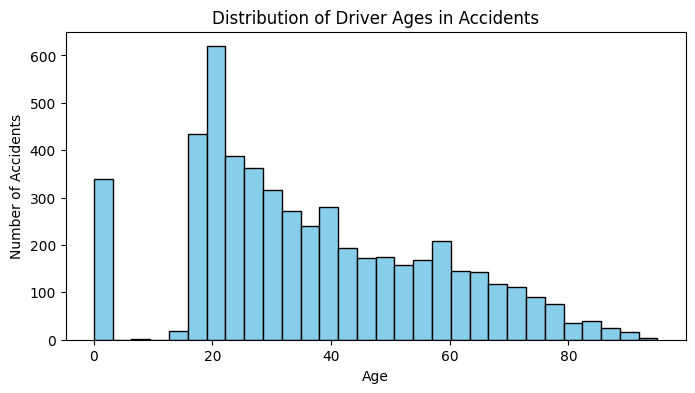

In [83]:
df['AGE_1'] = pd.to_numeric(df['AGE_1'], errors='coerce')

fig, ax = plt.subplots(figsize=(8, 4))
df['AGE_1'].dropna().hist(bins=30, ax=ax, color='skyblue', edgecolor='black')
ax.set_title('Distribution of Driver Ages in Accidents')
ax.set_xlabel('Age')
ax.set_ylabel('Number of Accidents')
plt.grid(False)
plt.show()

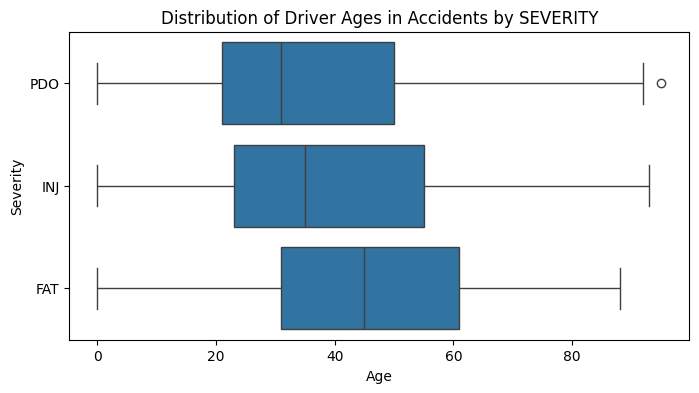

In [55]:
df['AGE_1'] = pd.to_numeric(df['AGE_1'], errors='coerce')

plt.figure(figsize=(8, 4))
sns.boxplot(x='AGE_1', y='SEVERITY', data=df.dropna(subset=['AGE_1']), orient='h')
plt.title('Distribution of Driver Ages in Accidents by SEVERITY')
plt.xlabel('Age')
plt.ylabel('Severity')
plt.grid(False)
plt.show()

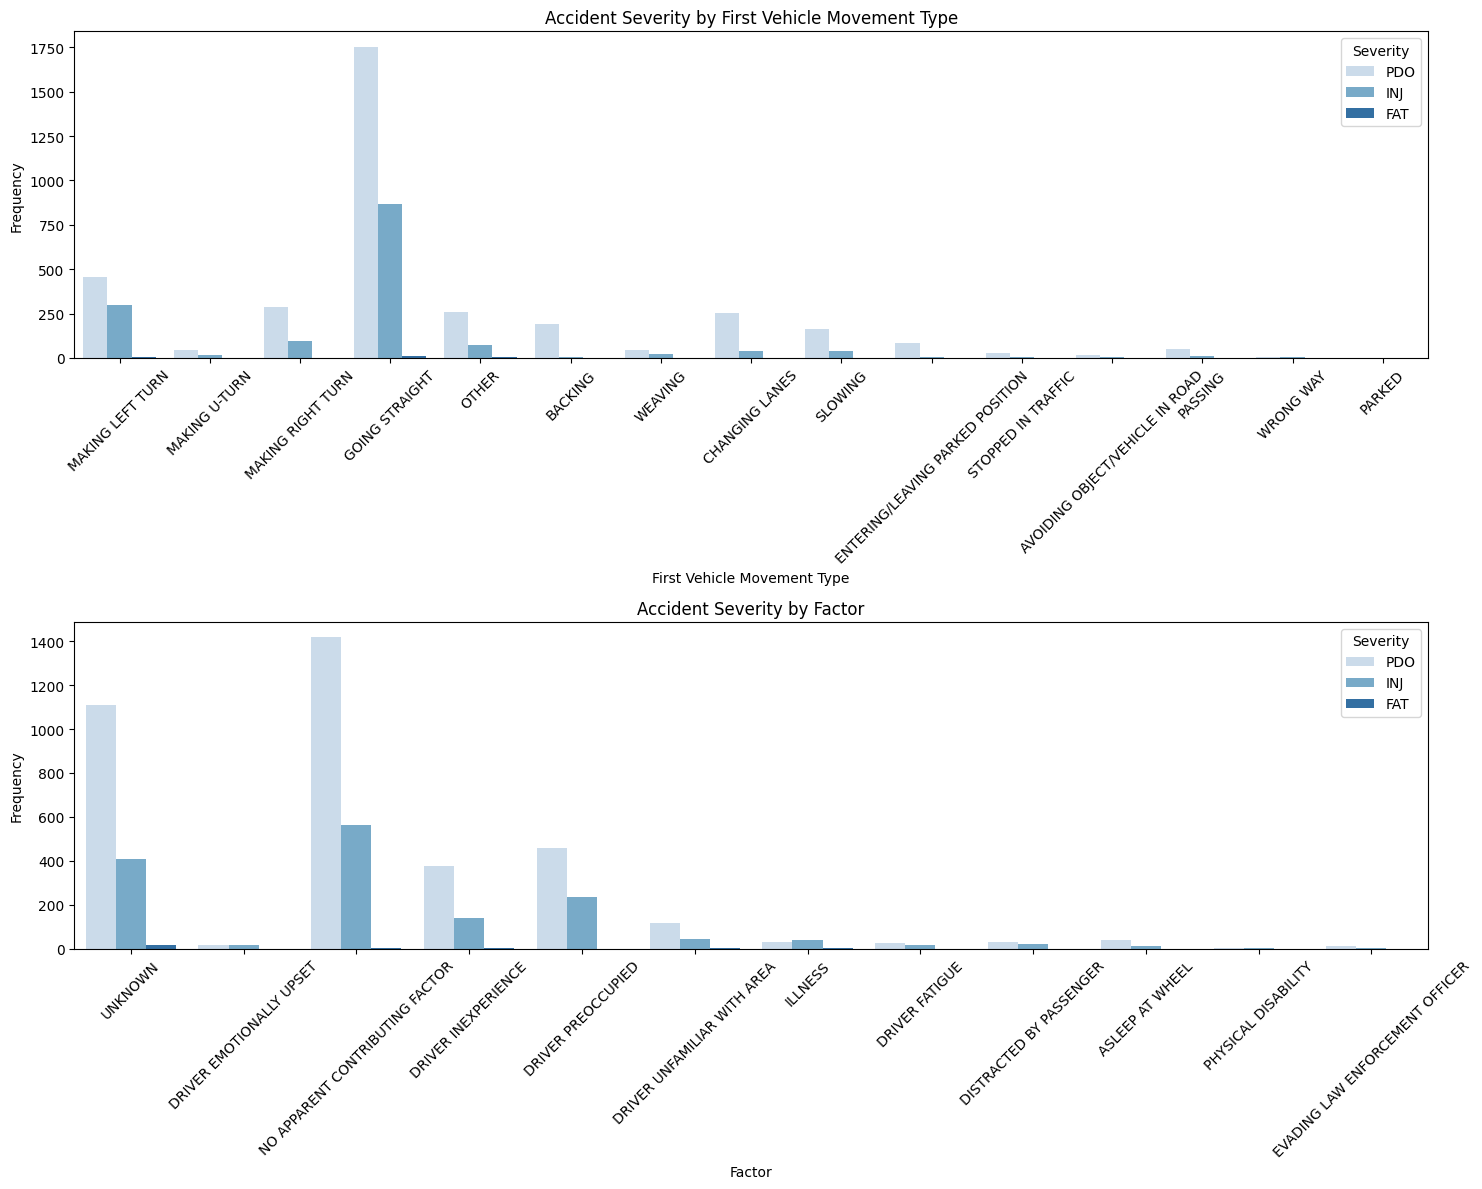

In [89]:
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

veh_move_plot = sns.countplot(x='VEH_MOVE_1', hue='SEVERITY', data=df, ax=axes[0], palette='Blues')
axes[0].set_title('Accident Severity by First Vehicle Movement Type')
axes[0].set_xlabel('First Vehicle Movement Type')
axes[0].set_ylabel('Frequency')
axes[0].legend(title='Severity')

for item in axes[0].get_xticklabels():
    item.set_rotation(45)

factor_plot = sns.countplot(x='FACTOR_1', hue='SEVERITY', data=df, ax=axes[1], palette='Blues')
axes[1].set_title('Accident Severity by Factor')
axes[1].set_xlabel('Factor')
axes[1].set_ylabel('Frequency')
axes[1].legend(title='Severity')

for item in axes[1].get_xticklabels():
    item.set_rotation(45)

plt.tight_layout()
plt.show()

## Correlation Analysis

In [94]:
# Numeric Columns
df['DATE'] = pd.to_datetime(df['DATE'])
df['MONTH'] = df['DATE'].dt.month
df['HOUR'] = df['TIME'] // 100

numeric_columns = ['MONTH','HOUR', 'MAX_T', 'MIN_T', 'PRECIPITATION', 'SNOW',
                      'SNOW_DEPTH', 'VEHICLES',
                      'SPEED_VS_LIMIT', 'AGE_1']

df['SEVERITY_PDO'] = (df['SEVERITY'] == 'PDO').astype(int)
df['SEVERITY_INJ'] = (df['SEVERITY'] == 'INJ').astype(int)
df['SEVERITY_FAT'] = (df['SEVERITY'] == 'FAT').astype(int)

severity_pdo_correlation = df[numeric_columns + ['SEVERITY_PDO']].corr()['SEVERITY_PDO'].drop('SEVERITY_PDO')
severity_inj_correlation = df[numeric_columns + ['SEVERITY_INJ']].corr()['SEVERITY_INJ'].drop('SEVERITY_INJ')
severity_fat_correlation = df[numeric_columns + ['SEVERITY_FAT']].corr()['SEVERITY_FAT'].drop('SEVERITY_FAT')

severity_correlations_numeric = pd.DataFrame({
    'PDO': severity_pdo_correlation,
    'INJ': severity_inj_correlation,
    'FAT': severity_fat_correlation
})

severity_correlations_numeric

,PDO,INJ,FAT
MONTH,-0.020746,0.020289,0.003860
HOUR,-0.044743,0.045991,-0.007575
MAX_T,-0.078326,0.075347,0.023498
MIN_T,-0.075633,0.072418,0.025097
PRECIPITATION,0.022478,-0.023979,0.010028
SNOW,0.041311,-0.040885,-0.004243
SNOW_DEPTH,0.055990,-0.056999,0.005550
VEHICLES,-0.119689,0.117798,0.016966
SPEED_VS_LIMIT,-0.066861,0.055762,0.080962
AGE_1,-0.087287,0.082980,0.033209


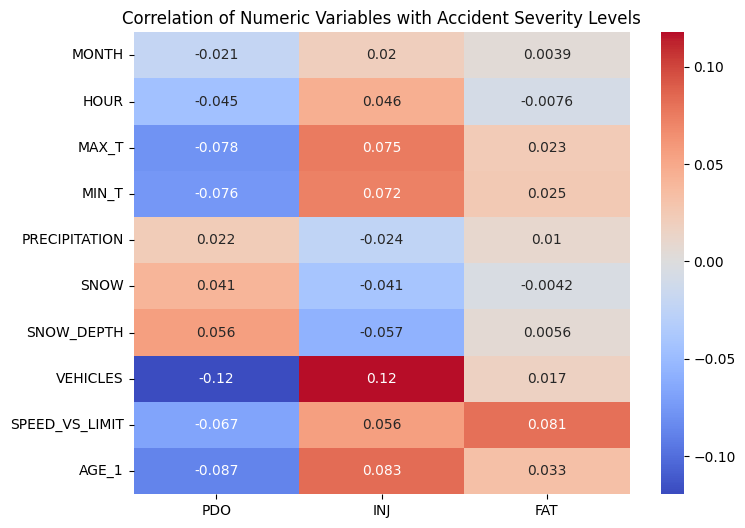

In [92]:
plt.figure(figsize=(8, 6))
sns.heatmap(severity_correlations_numeric, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of Numeric Variables with Accident Severity Levels')
plt.show()

In [95]:
# Boolean Columns
boolean_columns = ['IN_STATE', 'IMPAIRMENT', 'SPEEDING', 'URBAN', 'ANIMAL']

df['SEVERITY_PDO'] = (df['SEVERITY'] == 'PDO').astype(int)
df['SEVERITY_INJ'] = (df['SEVERITY'] == 'INJ').astype(int)
df['SEVERITY_FAT'] = (df['SEVERITY'] == 'FAT').astype(int)

severity_pdo_correlation = df[boolean_columns + ['SEVERITY_PDO']].corr()['SEVERITY_PDO'].drop('SEVERITY_PDO')
severity_inj_correlation = df[boolean_columns + ['SEVERITY_INJ']].corr()['SEVERITY_INJ'].drop('SEVERITY_INJ')
severity_fat_correlation = df[boolean_columns + ['SEVERITY_FAT']].corr()['SEVERITY_FAT'].drop('SEVERITY_FAT')

severity_correlations_bool = pd.DataFrame({
    'PDO': severity_pdo_correlation,
    'INJ': severity_inj_correlation,
    'FAT': severity_fat_correlation
})

severity_correlations_bool

,PDO,INJ,FAT
IN_STATE,-0.067894,0.068108,0.000459
IMPAIRMENT,-0.047550,0.038459,0.066106
SPEEDING,-0.067206,0.051933,0.110683
URBAN,0.154161,-0.150153,-0.033041
ANIMAL,0.047079,-0.046247,-0.007298


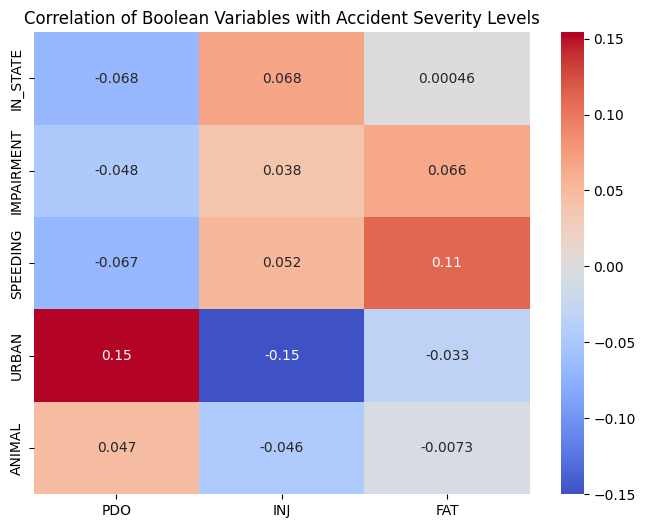

In [96]:
plt.figure(figsize=(8, 6))
sns.heatmap(severity_correlations_bool, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of Boolean Variables with Accident Severity Levels')
plt.show()

In [98]:
categorical_columns = ['SYSTEM', 'ROAD_DESC', 'CONDITION', 'WEATHER',
                       'ACCTYPE', 'VEHICLE_1',
                       'VEH_MOVE_1', 'SEX_1', 'FACTOR_1']

dummies = pd.get_dummies(df[categorical_columns])
df = df.join(dummies)

prefixes = ['SYSTEM_', 'ROAD_DESC_', 'CONDITION_', 'WEATHER_', 'ACCTYPE_', 'VEHICLE_1_', 'VEH_MOVE_1_', 'SEX_1_', 'FACTOR_1_']

for prefix in prefixes:
    condition_columns = [col for col in df.columns if col.startswith(prefix)]

    df['SEVERITY_PDO'] = (df['SEVERITY'] == 'PDO').astype(int)
    df['SEVERITY_INJ'] = (df['SEVERITY'] == 'INJ').astype(int)
    df['SEVERITY_FAT'] = (df['SEVERITY'] == 'FAT').astype(int)

    condition_pdo_correlation = df[condition_columns + ['SEVERITY_PDO']].corr()['SEVERITY_PDO'].drop('SEVERITY_PDO')
    condition_inj_correlation = df[condition_columns + ['SEVERITY_INJ']].corr()['SEVERITY_INJ'].drop('SEVERITY_INJ')
    condition_fat_correlation = df[condition_columns + ['SEVERITY_FAT']].corr()['SEVERITY_FAT'].drop('SEVERITY_FAT')

    condition_correlations = pd.DataFrame({
        'PDO': condition_pdo_correlation,
        'INJ': condition_inj_correlation,
        'FAT': condition_fat_correlation
    })

    print(f"Correlations for prefix '{prefix}':")
    print(condition_correlations)
    print('\n')

Correlations for prefix 'SYSTEM_':
                           PDO       INJ       FAT
SYSTEM_CITY STREET    0.114505 -0.115759  0.005579
SYSTEM_COUNTY ROAD   -0.067019  0.064449  0.020252
SYSTEM_STATE HIGHWAY -0.081726  0.084256 -0.015617


Correlations for prefix 'ROAD_DESC_':
                                     PDO       INJ       FAT
ROAD_DESC_AT DRIVEWAY ACCESS    0.006141 -0.008676  0.017862
ROAD_DESC_AT INTERSECTION      -0.095556  0.097505 -0.011081
ROAD_DESC_IN ALLEY              0.041196 -0.040643 -0.005144
ROAD_DESC_INTERSECTION RELATED  0.040713 -0.037339 -0.025205
ROAD_DESC_NON-INTERSECTION      0.040815 -0.044514  0.025138
ROAD_DESC_PARKING LOT           0.018012 -0.017835 -0.001786
ROAD_DESC_RAMP                  0.015851 -0.015140 -0.005522
ROAD_DESC_ROUNDABOUT            0.017095 -0.016379 -0.005595


Correlations for prefix 'CONDITION_':
                       PDO       INJ           FAT
CONDITION_DRY    -0.057397  0.057593  2.841919e-04
CONDITION_ICY     0.034238 -0.